In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Carregar o dataset
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Atributos:

* RowNumber - Número da linha
* CustomerId - Identificador do Cliente
* Surname - Sobrenome
* CreditScore - Pontuação de crédito
* Geography - País do Cliente
* Gender - Gênero
* Age - Idade
* Tenure - O número de meses ou anos que o cliente mantém o serviço.
* Balance - Saldo
* NumOfProducts - Número de produtos
* HasCrCard - Se o cliente tem ou não cartão de crédito
* IsActiveMember - Se o cliente é um membro ativo
* Estimated Salary - Salário estimado
* Exited - Se o cliente cancelou ou não o vínculo com o banco





---



**PRÉ-PROCESSAMENTO**

In [172]:
# Verificar valores nulos antes do preenchimento
print("Valores nulos antes do preenchimento:")
print(df.isnull().sum())

Valores nulos antes do preenchimento:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Não tem valores nulos no dataset



---



Procurar por linhas duplicadas

In [173]:
duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='Count')

# Filtrar para mostrar apenas as linhas que têm duplicatas
duplicates_only = duplicate_counts[duplicate_counts['Count'] > 1]

# Exibir os resultados
print(duplicates_only)

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Count]
Index: []


Não tem valores duplicados no dataset



---



Balanceamento entre as classes

In [174]:
df_majority = df[df['Exited'] == 0]  # Classe majoritária
df_minority = df[df['Exited'] == 1]  # Classe minoritária

# Pega o número de amostras da classe minoritária
n_minority_samples = len(df_minority)

# Realizar o undersampling da classe majoritária para ter o mesmo número de amostras que a classe minoritária
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # Sem duplicação
                                   n_samples=n_minority_samples,  # Número de amostras igual ao da classe minoritária
                                   random_state=42)

# Combinar novamente o dataset com a classe minoritária inalterada
df = pd.concat([df_minority, df_majority_downsampled])



---



Deletar colunas irrelevantes

In [175]:
df.drop(columns=['CustomerId','RowNumber', 'Surname'],inplace=True)



---



Codificar variáveis categóricas

In [176]:
df['Geography'] = df.Geography.map({"France":0, "Spain":1, "Germany":2})
df['Gender'] = df.Gender.map({"Male":0, "Female":1})



---



**ANÁLISE EXPLORTÓRIA DE DADOS**

Busca de alguma relação entre a variável alvo e os demais atributos

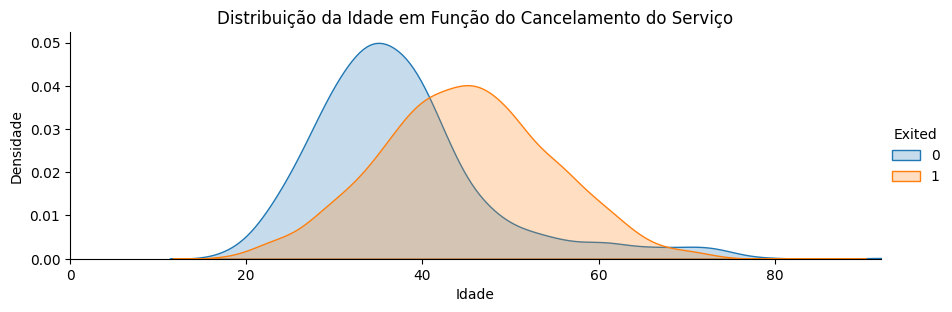

In [177]:
facet = sns.FacetGrid(df, hue="Exited",aspect=3)
facet.map(sns.kdeplot,"Age",fill= True)
facet.set(xlim=(0, df["Age"].max()))
facet.add_legend()

plt.title("Distribuição da Idade em Função do Cancelamento do Serviço")
plt.xlabel("Idade")
plt.ylabel("Densidade")
plt.show()

Pessoas na faixa de (aproximadamente) 40 até 70 anos são mais propensas a cancelarem o serviço.



---



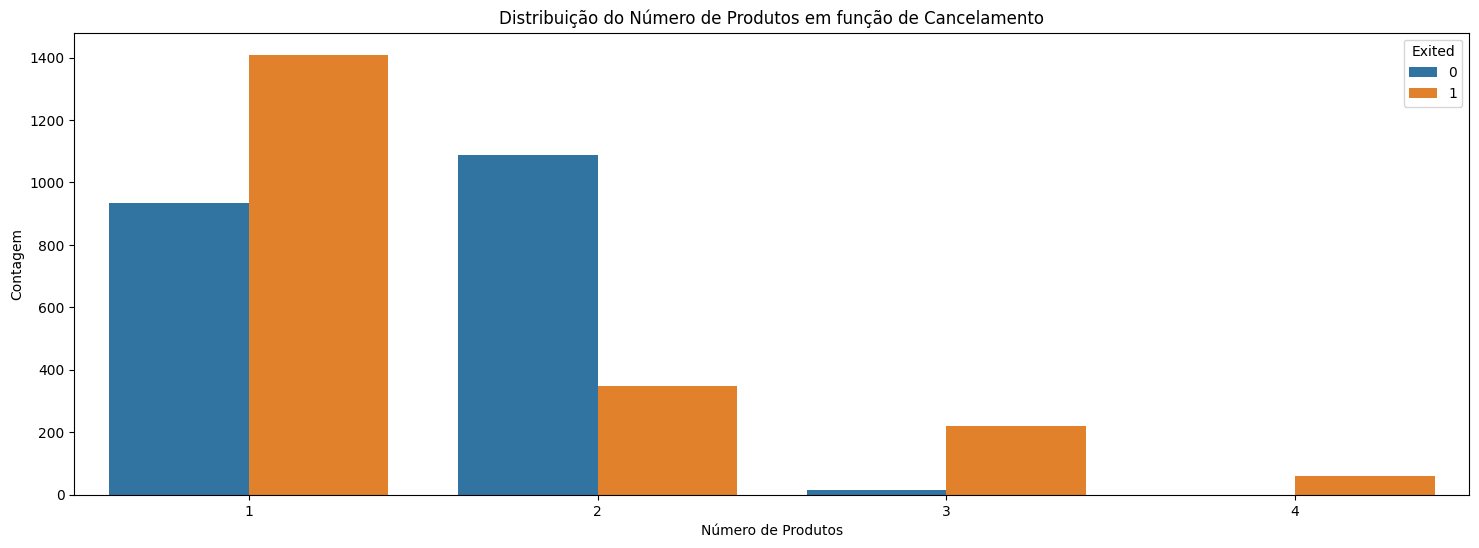

In [178]:
_, ax = plt.subplots(1, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="NumOfProducts", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição do Número de Produtos em função de Cancelamento')
ax.set_xlabel('Número de Produtos')
ax.set_ylabel('Contagem')

plt.show()


É perceptível que NumOfProducts tem um forte relação com os clientes que cancelaram

In [179]:
df[['NumOfProducts', 'Exited']].groupby(['NumOfProducts'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,NumOfProducts,Exited
3,4,1.000000
2,3,0.936170
0,1,0.601366
1,2,0.242340




---



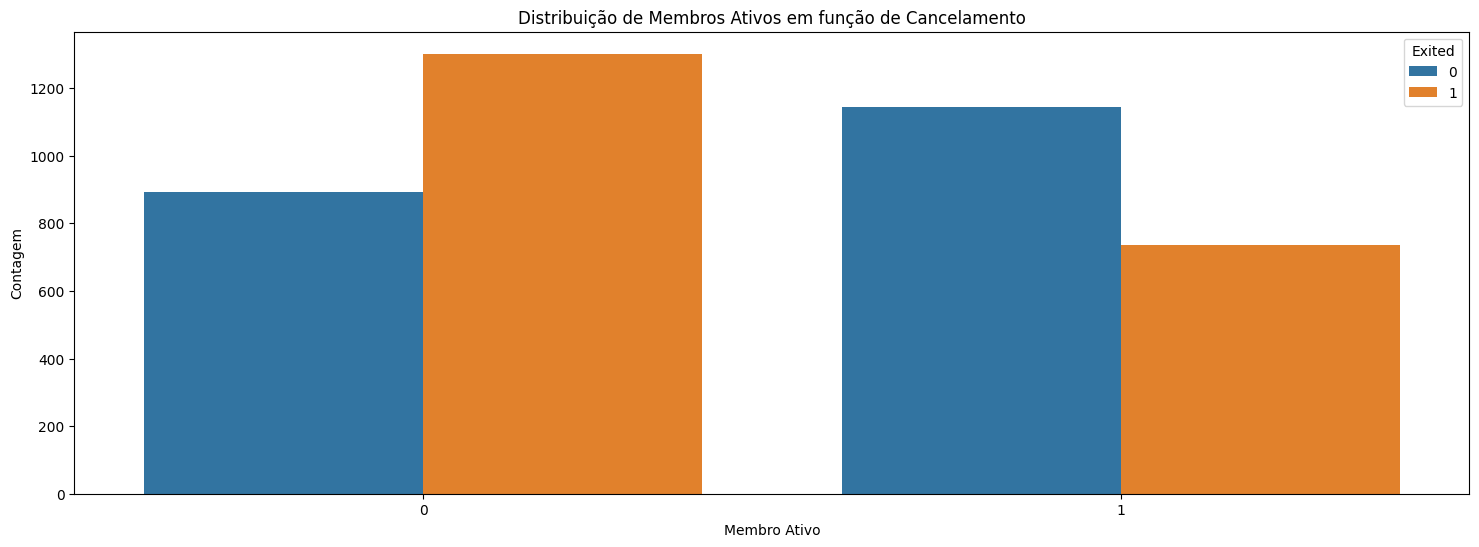

In [180]:
_, ax = plt.subplots(1, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="IsActiveMember", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição de Membros Ativos em função de Cancelamento')
ax.set_xlabel('Membro Ativo')
ax.set_ylabel('Contagem')

plt.show()

Se o membro é ativo(1), tem menos chance de cancelar. Se o membro não é ativo(0), tem mais chance de cancelar

In [181]:
df[['IsActiveMember', 'Exited']].groupby(['IsActiveMember'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,IsActiveMember,Exited
0,0,0.593437
1,1,0.390957




---



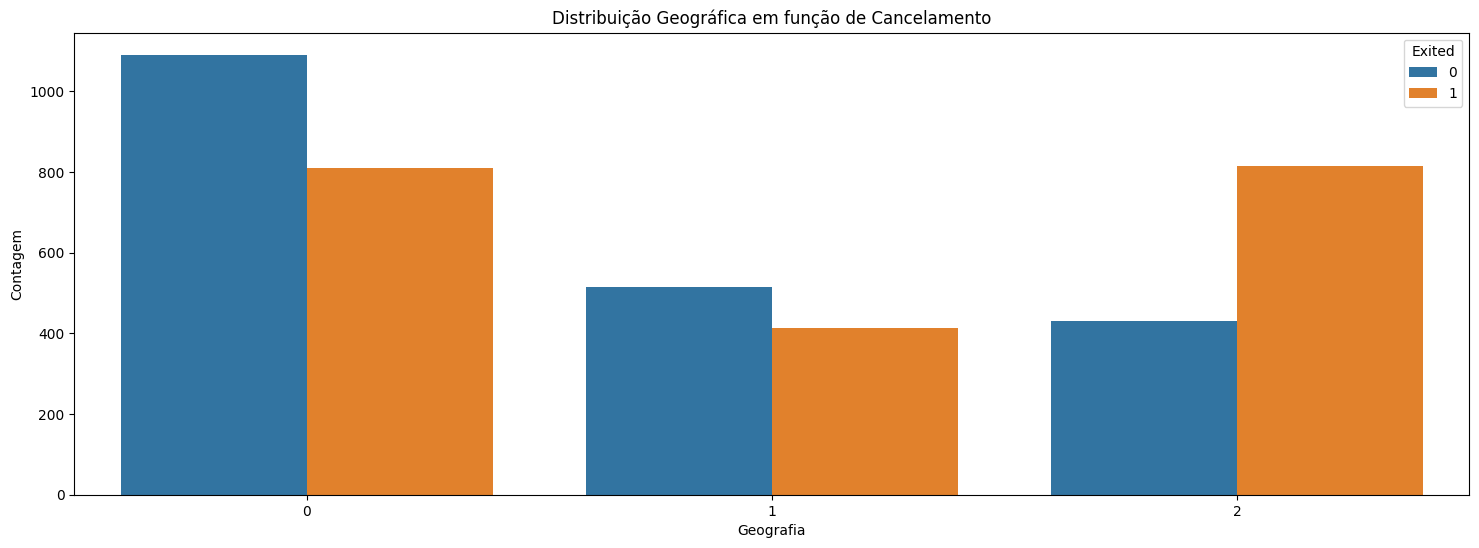

In [182]:
_, ax = plt.subplots(1, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="Geography", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição Geográfica em função de Cancelamento')
ax.set_xlabel('Geografia')
ax.set_ylabel('Contagem')

plt.show()

Se for da Alemanha é bastante provável que cancele

1.   Se a pessoa é da França é provável que não cancele.
2.   Se a pessoa for da Alemanha é bastante provável que cancele.





---



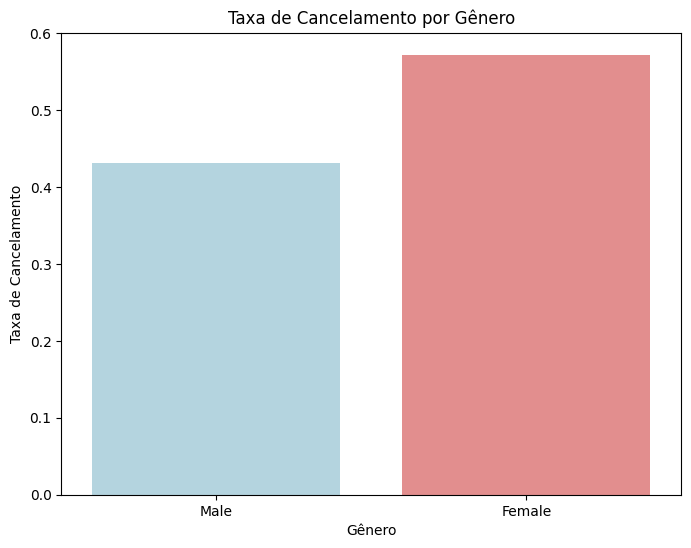

In [183]:
churn_by_gender = df.groupby('Gender')['Exited'].mean().reset_index()

# Alterar o nome dos gêneros se necessário (para evitar 0 e 1)
churn_by_gender['Gender'] = churn_by_gender['Gender'].map({0: 'Male', 1: 'Female'})

# Criando o gráfico de barras
plt.figure(figsize=(8, 6))

# Usando hue para evitar o erro de paleta
sns.barplot(data=churn_by_gender, x='Gender', y='Exited', hue='Gender', palette={'Male': 'lightblue', 'Female': 'lightcoral'})

plt.title('Taxa de Cancelamento por Gênero')

plt.xlabel('Gênero')
plt.ylabel('Taxa de Cancelamento')
plt.xlabel('Gênero')

plt.show()

Homens tem menos chance de cancelar e mulheres tem mais chance de cancelar, de acordo com o dataset.

O número de homens e mulheres é bem parelho no dataset

In [191]:
gender_counts = df['Gender'].value_counts()
print(gender_counts)

Gender
0    2084
1    1990
Name: count, dtype: int64


In [184]:
df[['Gender', 'Exited']].groupby(['Gender'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,Gender,Exited
1,1,0.572362
0,0,0.430902




---



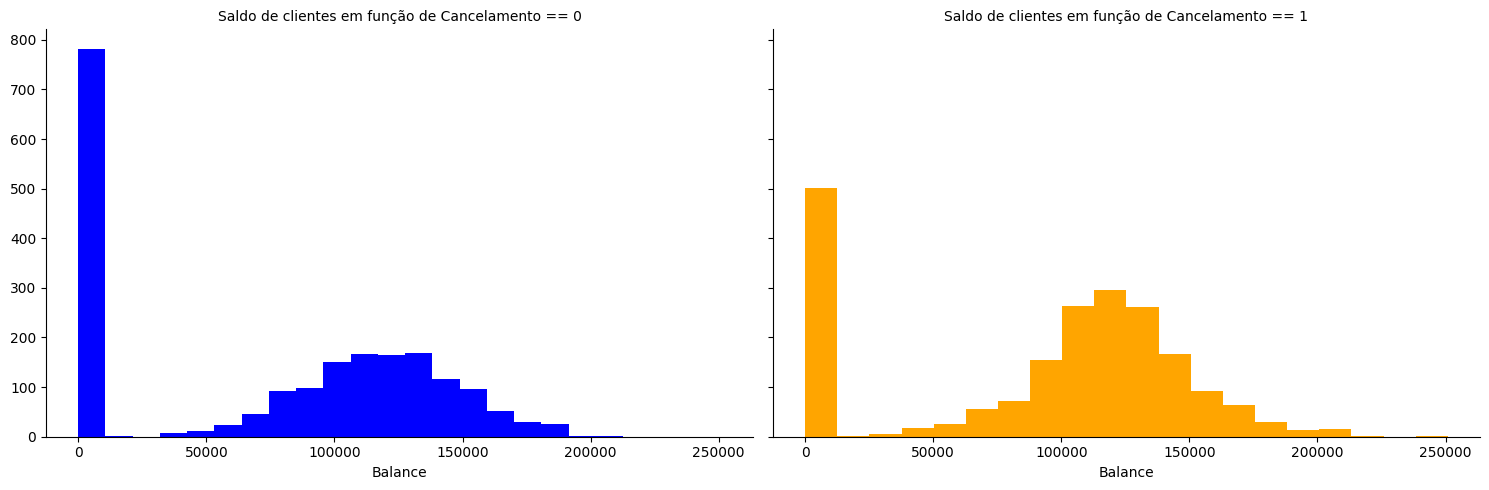

In [185]:
g = sns.FacetGrid(df, col='Exited', height=5, aspect=1.5)

g.map(plt.hist, 'Balance', bins=20, color='gray')

colors = ['blue', 'orange']

for ax, color in zip(g.axes.flatten(), colors):
    for patch in ax.patches:
        patch.set_facecolor(color)

g.set_titles(col_template="Saldo de clientes em função de Cancelamento == {col_name}")

plt.show()

Pessoas com saldo entre por volta de 80000 até 160000 são mais propensas a cancelar. Pessoas com saldo zero são menos propensas a cancelar



---



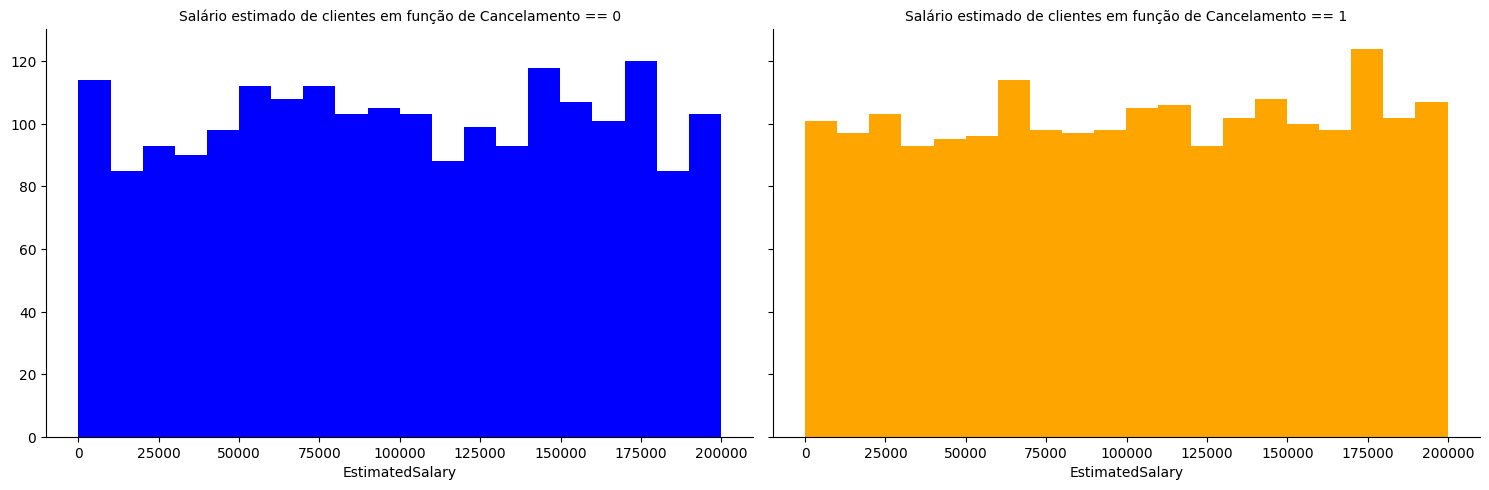

In [186]:
g = sns.FacetGrid(df, col='Exited', height=5, aspect=1.5)

g.map(plt.hist, 'EstimatedSalary', bins=20, color='gray')

colors = ['blue', 'orange']

for ax, color in zip(g.axes.flatten(), colors):
    for patch in ax.patches:
        patch.set_facecolor(color)

g.set_titles(col_template="Salário estimado de clientes em função de Cancelamento == {col_name}")

plt.show()

O salário estimado não é tão interessante para o modelo, pois não tem nenhuma correlação com o numero de pessoas que cancelaram. Ambos gráficos estão bem equilibrados. O mesmo vale para todas outras colunas retiradas do dataset.



---



**TREINO**

Treino Naive Bayes

In [187]:
#deletando colunas
df_NB = df.copy()
df_NB.drop(columns=['CreditScore', 'Tenure','HasCrCard',
                    ],inplace=True)

display(df_NB)#mostra como ficou o dataset

print(df_NB['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_NB.drop('Exited', axis=1)
y = df_NB['Exited']

# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformar X_train escalado em um DataFrame para melhor visualização
X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)

# Treinar o modelo Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred = model.predict(X_test)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
0,0,1,42,0.00,1,1,101348.88,1
2,0,1,42,159660.80,3,0,113931.57,1
5,1,0,44,113755.78,2,0,149756.71,1
7,2,1,29,115046.74,4,0,119346.88,1
16,2,0,58,132602.88,1,0,5097.67,1
...,...,...,...,...,...,...,...,...
9918,1,0,31,132862.59,1,0,158054.49,0
7710,0,1,40,0.00,1,1,144345.58,0
5156,1,0,33,127343.40,1,1,121789.30,0
3104,2,0,31,145537.21,1,0,132404.64,0


Exited
1    2037
0    2037
Name: count, dtype: int64
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       408
           1       0.76      0.73      0.75       407

    accuracy                           0.75       815
   macro avg       0.75      0.75      0.75       815
weighted avg       0.75      0.75      0.75       815


Confusion Matrix:
 [[312  96]
 [108 299]]


Treino KNN

In [188]:
#deletando colunas
df_KNN = df.copy()
df_KNN.drop(columns=['CreditScore','Tenure', 'HasCrCard',
                      'EstimatedSalary'],inplace=True)

display(df_KNN.head())#mostra como ficou o dataset
print(df_KNN.dtypes.to_frame(name='Data Type').reset_index())

print(df_KNN['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_KNN.drop('Exited', axis=1)
y = df_KNN['Exited']


# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Você pode ajustar o número de vizinhos
knn.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred = knn.predict(X_test)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited
0,0,1,42,0.00,1,1,1
2,0,1,42,159660.80,3,0,1
5,1,0,44,113755.78,2,0,1
7,2,1,29,115046.74,4,0,1
16,2,0,58,132602.88,1,0,1


            index Data Type
0       Geography     int64
1          Gender     int64
2             Age     int64
3         Balance   float64
4   NumOfProducts     int64
5  IsActiveMember     int64
6          Exited     int64
Exited
1    2037
0    2037
Name: count, dtype: int64
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       306
           1       0.80      0.80      0.80       306

    accuracy                           0.80       612
   macro avg       0.80      0.80      0.80       612
weighted avg       0.80      0.80      0.80       612


Confusion Matrix:
 [[244  62]
 [ 62 244]]


Treino Redes Neurais

In [189]:
#deletando colunas
df_RN = df.copy()
df_RN.drop(columns=['CreditScore', 'Tenure', 'HasCrCard',
                    'IsActiveMember', 'EstimatedSalary'],inplace=True)

display(df_RN.head())#mostra como ficou o dataset

print(df_RN['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_RN.drop('Exited', axis=1)
y = df_RN['Exited']

# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criar o modelo da rede neural
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))  # Primeira camada oculta
model.add(Dense(16, activation='relu'))  # Segunda camada oculta
model.add(Dense(1, activation='sigmoid'))  # Camada de saída para classificação binária

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Fazer previsões e avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convertendo as previsões para 0 ou 1

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,Balance,NumOfProducts,Exited
0,0,1,42,0.00,1,1
2,0,1,42,159660.80,3,1
5,1,0,44,113755.78,2,1
7,2,1,29,115046.74,4,1
16,2,0,58,132602.88,1,1


Exited
1    2037
0    2037
Name: count, dtype: int64
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5785 - loss: 0.7081 - val_accuracy: 0.6933 - val_loss: 0.6142
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7060 - loss: 0.5926 - val_accuracy: 0.7178 - val_loss: 0.5737
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7409 - loss: 0.5456 - val_accuracy: 0.7147 - val_loss: 0.5542
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.5463 - val_accuracy: 0.7193 - val_loss: 0.5414
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7438 - loss: 0.5242 - val_accuracy: 0.7239 - val_loss: 0.5341
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7596 - loss: 0.5183 - val_accuracy: 0.7347 - val_loss: 0.5269
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7413 - loss: 0.5274 - val_accuracy: 0.7331 - val_loss: 0.5226
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.5090 - val_accuracy: 0.7347 - val_loss: 0.5194
Epo